# 3. Linear Models for Regression

### *Table of Contents*

* 3.1 [Linear Basis Function Models](#3.1-Linear-Basis-Function-Models)
    * 3.1.1 [Maximum likelihood and least squares](#3.1.1-Maximum-likelihood-and-least-squares)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

The goal of regression is to predict the value of one or more **continuous** target variables $t$ given the value of a $D$-dimensional vector $\mathbf{x}$ of input variables. The polynomial curve that we used in [Chapter 1](ch1_introduction.ipynb) belongs to a broader class of functions called linear regression models,
that are linear functions of the adjustable parameters. The simplest form of linear regression models are also linear functions of the input variables $\mathbf{x}$. However, a much more useful class of functions is the linear combinations of a fixed set of nonlinear functions of the input variables, known as *basis functions*.

## 3.1 Linear Basis Function Models

The simplest linear model for regression is one that involves a linear combination of the input variables

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + w_1x_1 + \dots + w_Dx_D
$$

which is simply known as *linear regression*. This model is a linear function of the parameters and a linear function of the input variables, and this imposes significant limitations on the model. We therefore extend the class of models by considering linear combinations of fixed nonlinear functions of the input variables, of the form

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{M-1} w_j\phi_j(\mathbf{x})
$$

where $\phi_j(\mathbf{x})$ are known as *basis functions*.

The polynomial regression considered in [Chapter 1](ch1_introduction.ipynb) is an example of this model in which there is a single input variable $x$, and the basis functions take the form of powers of $x$ so that $\phi_j(x)=x^j$.

There are many possible choices for the basis functions, for example

$$
\phi_j(x) = \exp\bigg\{ \frac{(x - \mu_j)^2}{2s^2} \bigg\}
$$

are referred to as *Gaussian* basis functions, where $\mu_j$ govern the locations of the functions in input space, and $s$ governs their spatial scale.

Another possibility is the sigmoidal basis function of the form

$$
\phi_j(x) = \sigma\bigg( \frac{x - \mu_j}{s} \bigg)
$$

where $\sigma(a)$ is the logistic sigmoid function defined by

$$
\sigma(a) = \frac{1}{1 + \exp(-a)}
$$

### 3.1.1 Maximum likelihood and least squares

In Chapter 1, we fitted polynomial functions to data sets by minimizing a sum-of-squares error function. We also showed that this error function could be motivated as the maximum likelihood solution under an assumed Gaussian noise model. Let us return to the discussion of [Chapter 1](ch1_introduction.ipynb) and consider the least squares approach, and its relation to maximum likelihood, in more detail.

As before, we assume that the target variable $t$ is given by a deterministic function $y(\mathbf{x},\mathbf{w})$ having additive Gaussian noise so that

$$
t = y(\mathbf{x},\mathbf{w}) + \epsilon
$$

where $\epsilon$ is a zero mean Gaussian random variable with precision (inverse variance) $\beta$. Thus we can write

$$
p(t|\mathbf{x},\mathbf{w},\beta) = \mathcal{N}(t|y(\mathbf{x},\mathbf{w}),\beta^{-1})
$$

Note that the Gaussian noise assumption implies that the conditional distribution of $t$ given $\mathbf{x}$ is unimodal, which may be inappropriate for some applications.

Now consider a data set of inputs $\mathbf{X}=\{\mathbf{x}_1,\dots,\mathbf{x}_N\}$ along corresponding target alues $\mathsf{t}=(t_1,\dots,t_N)^{\text{T}}$. Assuming that the data points are i.i.d, we obtain the likelihood function (function of the adjustable parameters $\mathbf{w}$ and $\beta$), in the form

$$
p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) = 
\prod_{n=1}^N \mathcal{N}(t_n|y(\mathbf{x}_n,\mathbf{w}),\beta^{-1}) = 
\prod_{n=1}^N \mathcal{N}(t_n|\mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n),\beta^{-1})
$$

**NOTE**: In many textbooks, the input variables $\mathbf{x}$ are dropped from the set of conditioning variables, since, we do not seek to model the distribution of $\mathbf{x}$.

Taking the logarithm of the likelihood function, we have,

$$
\begin{align*}
\ln p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) &= 
\sum_{n=1}^N \ln\mathcal{N}(t_n|\mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n),\beta^{-1}) \\
&= \frac{N}{2}\ln\beta - \frac{N}{2}\ln 2\pi - 
\frac{\beta}{2}\sum_{n=1}^N \big(t_n - \mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n)\big)^2 \\
&= \frac{N}{2}\ln\beta - \frac{N}{2}\ln 2\pi - \beta E_D(\mathbf{w})
\end{align*}
$$

By maximizing likelihood we can determine the parameters $\mathbf{w}$ and $\beta$. As already observed in [Chapter 1](ch1_introduction.ipynb) the maximization under a conditional Gaussian noise distribution is equivalent to minimizing the sum-of-squares error function given by $E_D(\mathbf{w})$. The gradient of the log likelihood function takes the form

$$
\nabla p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) = 
\sum_{n=1}^N \big(t_n - \mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n)\big)\phi(\mathbf{x}_n)^{\text{T}}
$$

Setting this gradient to zero and solving for $\mathbf{w}$ gives

$$
\mathbf{w}_{ML} = (\mathbf{\Phi}^{\text{T}}\mathbf{\Phi})^{-1}\mathbf{\Phi}^{\text{T}}\mathsf{t}
$$

which are known as the normal equations for the least squares problem. Here $\mathbf{\Phi}$ is an $N\times M$ matrix, called the *design matrix*, whose elements are given by $\Phi_{nj} = \phi_j(\mathbf{x}_n)$, so that

$$
\mathbf{\Phi}= 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) & \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\
\phi_0(\mathbf{x}_2) & \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots  & \vdots  & \ddots & \vdots  \\
\phi_0(\mathbf{x}_N) & \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
\end{pmatrix}
$$

By maximizing the log likelihood function over the noise precision parameter $\beta$, we obtain

$$
\beta_{ML} = \frac{1}{N}\sum_{n=1}^N (t_n - \mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n))^2
$$

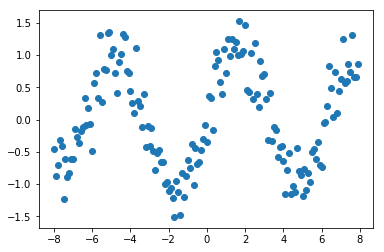

In [6]:
X = np.arange(-8, 8, 0.1).reshape((-1,1))
y = np.sin(X) + np.random.randn(X.shape[0], X.shape[1]) * 0.3
plt.scatter(X, y)